In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['gender_submission.csv', 'test.csv', 'train.csv']


In [2]:
from fastai import *
from fastai.tabular import *

In [3]:
df_train = pd.read_csv("../input/train.csv")
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df_test = pd.read_csv("../input/test.csv")
#df_test.head()

In [5]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
#getting the Title from name
#getting the first letter from Cabin

for df in [df_train, df_test]:
    df['Title'] = df['Name'].str.split(',').str[1].str.split(' ').str[1]
    df['Deck'] = df['Cabin'].str[0]

In [7]:
#concat the to data_frames

all_df = pd.concat([df_train, df_test], sort = False)
all_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr.,NaN
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss.,NaN
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs.,C
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr.,NaN


In [8]:
# find mean age for each Title across train and test data sets
mean_age_by_title = all_df.groupby(['Title']).mean()['Age']
mean_age_by_title

Title
Capt.        70.000000
Col.         54.000000
Don.         40.000000
Dona.        39.000000
Dr.          43.571429
Jonkheer.    38.000000
Lady.        48.000000
Major.       48.500000
Master.       5.482642
Miss.        21.774238
Mlle.        24.000000
Mme.         24.000000
Mr.          32.252151
Mrs.         36.994118
Ms.          28.000000
Rev.         41.250000
Sir.         49.000000
the          33.000000
Name: Age, dtype: float64

In [9]:
# update missing ages
for df in [df_train, df_test]:
    for title, age in mean_age_by_title.iteritems():
        df.loc[df['Age'].isnull() & (df['Title'] == title), 'Age'] = age

In [10]:
df_test.Fare.fillna(0,inplace=True)

In [11]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr.,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss.,NaN
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs.,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr.,NaN


In [12]:
dep_var = 'Survived'
cat_vars = ['Pclass','Sex','SibSp','Parch','Embarked','Title','Deck']
cont_vars = ['Age','Fare']
procs = [FillMissing, Categorify, Normalize]

In [13]:
valid_idx = range(len(df_train)-100, len(df_train))
data = (TabularList.from_df(df_train, procs=procs, cont_names=cont_vars, cat_names=cat_vars)
        .split_by_idx(valid_idx)
        .label_from_df(cols=dep_var)
        .add_test(TabularList.from_df(df_test, cat_names=cat_vars, cont_names=cont_vars, procs=procs))
        .databunch())
print(data.train_ds.cont_names)
print(data.train_ds.cat_names)

['Age', 'Fare']
['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Title', 'Deck']


In [14]:
np.random.seed(101)
learn = tabular_learner(data, layers=[200,100],emb_drop=0.2, metrics=accuracy)

In [15]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(4, 3)
    (1): Embedding(3, 3)
    (2): Embedding(8, 5)
    (3): Embedding(8, 5)
    (4): Embedding(4, 3)
    (5): Embedding(17, 8)
    (6): Embedding(9, 5)
  )
  (emb_drop): Dropout(p=0.2)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=34, out_features=200, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=200, out_features=100, bias=True)
    (4): ReLU(inplace)
    (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [16]:
data.show_batch(rows=10)

Pclass,Sex,SibSp,Parch,Embarked,Title,Deck,Age,Fare,target
3,female,0,2,S,Mrs.,G,-0.4416,-0.3176,1
1,male,0,0,C,Col.,A,1.9620,0.0455,1
1,male,1,0,C,Mr.,E,-0.3665,0.4307,1
2,male,0,0,S,Mr.,#na#,0.0841,-0.3891,1
2,male,0,0,S,Mr.,#na#,-0.2163,-0.3891,0
3,male,1,1,C,Mr.,#na#,-1.1177,-0.5006,0
3,male,5,2,S,Master.,#na#,-2.1693,0.2657,0
2,male,0,0,S,Mr.,#na#,-0.8923,-0.4181,0
3,female,1,0,C,Mrs.,#na#,0.5344,-0.3609,0
3,male,0,0,S,Mr.,#na#,0.4597,-0.4954,0


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-02


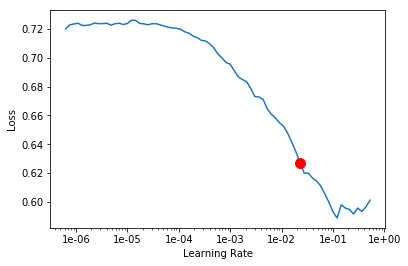

In [17]:
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [18]:
learn.fit_one_cycle(10, 5e-02, wd=1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.580671,0.636808,0.640000,00:00
1,0.522218,0.465208,0.770000,00:00
2,0.499808,0.390175,0.850000,00:00
3,0.489497,0.344534,0.870000,00:00
4,0.470864,0.333022,0.880000,00:00
5,0.451490,0.356761,0.850000,00:00
6,0.439669,0.330524,0.890000,00:00
7,0.426277,0.327661,0.890000,00:00
8,0.418339,0.327221,0.890000,00:00
9,0.410896,0.327706,0.880000,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-05


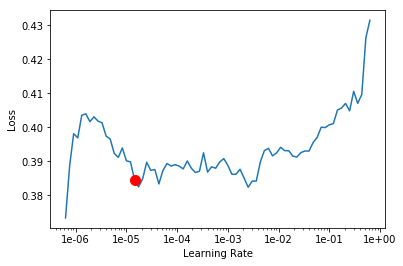

In [19]:
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [20]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-07))

epoch,train_loss,valid_loss,accuracy,time
0,0.388823,0.328687,0.880000,00:00
1,0.382920,0.327686,0.880000,00:00
2,0.385395,0.327929,0.880000,00:00
3,0.382107,0.326094,0.890000,00:00
4,0.383588,0.327771,0.880000,00:00
5,0.383843,0.327822,0.880000,00:00
6,0.384363,0.327095,0.880000,00:00
7,0.384812,0.326932,0.880000,00:00
8,0.383362,0.325794,0.890000,00:00
9,0.386570,0.326601,0.890000,00:00


In [21]:
predictions, *_ = learn.get_preds(DatasetType.Test)
labels = np.argmax(predictions, 1)

In [22]:
sub_df = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': labels})
sub_df.to_csv('submission.csv', index=False)

In [23]:
sub_df.tail()

,PassengerId,Survived
413,1305,0
414,1306,1
415,1307,0
416,1308,0
417,1309,1
